# Validação das tarefas de aprendizado

## Importações

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import Orange
from scipy.stats import friedmanchisquare
from sklearn.svm import SVC, SVR
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import StratifiedKFold, GridSearchCV, ShuffleSplit, KFold
from sklearn.metrics import accuracy_score, make_scorer, mean_squared_error

## Parâmetros gerais

In [2]:
n_splits = 10
random_state = 17

base = pd.read_csv('student-por.csv', sep = ";")

---

## Tarefa de classificação

### Função de pré-processamento

In [3]:
def preprocess_class(base):

    base = base.drop(['school'], axis=1)
    
    base = base.replace(['LE3', 'GT3'], [0,1])
    
    items = ['sex', 'address','Pstatus','Mjob','Fjob','reason','guardian','schoolsup','famsup','paid','activities','nursery','higher',
             'internet','romantic']
    
    for item in items:
        base = pd.concat([base,pd.get_dummies(base[item], prefix=item)],axis=1)
        base = base.drop([item],axis=1)
    
    base.loc[base['G3'] < 10, 'G3'] = 0
    base.loc[base['G3'] >= 10, 'G3'] = 1
    
    return base

### Função de treinamento e teste com base_class nos algoritmos escolhidos

In [4]:
def search_class(X, y, n_splits, random_state, algorithms):
    
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    gskf = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_state)
    perf = accuracy_score
    
    score = {}
    for algorithm in algorithms.keys():
        score[algorithm] = []
    
    for algorithm, (clf, parameters) in algorithms.items():
        for train, test in kf.split(X, y):
            prep = StandardScaler()
            prep.fit(X[train])
            best = GridSearchCV(clf, parameters, cv=gskf, scoring=make_scorer(perf))
            best.fit(prep.transform(X[train]), y[train])
            score[algorithm].append(perf(best.predict(prep.transform(X[test])), y[test]))
            
    df_metrics = pd.DataFrame.from_dict(score)
    return df_metrics

### Função que executa o teste de Friedman e Nemenyi (se necessário)

In [5]:
def friedman_nemenyi_tests_class(df_metrics, title):   
    
    df_score = df_metrics.rank(axis=1, ascending=False)
    
    stat, p = friedmanchisquare(*[grp for idx, grp in df_score.iteritems()])
    
    print('Statistics=%.3f, p=%g' % (stat, p))
    
    alpha = 0.05
    if p > alpha:
        print('Same distributions (fail to reject H0)')
    else:
        print("Different distributions (reject H0)")
        names = list(df_score.columns)
        avranks = df_score.mean().values.tolist()
        cd = Orange.evaluation.compute_CD(avranks, n_splits)
        Orange.evaluation.graph_ranks(avranks, names, cd=cd, width=6, textspace=1.5)
        plt.title(title)
        plt.show()
    return df_score

### Algoritmos e hiperparâmetros testados

In [6]:
algorithms_class = {
    "MLP": (MLPClassifier(), { "activation": ("identity", "logistic", "tanh", "relu"), "solver": ("lbfgs", "adam"), "max_iter": [1000], "random_state": [1]}), 
    "SVM": (SVC(), {"C": [1, 10], "kernel": ("linear", "rbf"), "random_state": [2]}),
    "KNN": (KNeighborsClassifier(), { "n_neighbors": [1, 3, 5] }),
    "DT" : (DecisionTreeClassifier(), { "criterion": ("gini", "entropy"), "max_depth": [5, 10, 20], "random_state": [3]}),
    "RF" : (RandomForestClassifier(), { "criterion": ("gini", "entropy"), "max_depth": [5, 10, 20], "n_estimators": [30,50,100], "random_state": [4]})
}

### Leitura da base_class, pré-processamento e definição do atributo-alvo

In [7]:
base_class = preprocess_class(base)

y = base_class['G3'].to_numpy()

### Combinação [  ]

#### Busca dos melhores modelos

In [8]:
X = base_class.drop(columns = ['G1','G2','G3']).to_numpy()
df_metrics_no_class = search_class(X,y,n_splits,random_state,algorithms_class)

###### Performance dos modelos

In [9]:
df_metrics_no_class

,MLP,SVM,KNN,DT,RF
0,0.830769,0.815385,0.800000,0.876923,0.846154
1,0.861538,0.876923,0.830769,0.846154,0.830769
2,0.815385,0.876923,0.846154,0.800000,0.861538
3,0.846154,0.861538,0.876923,0.830769,0.846154
4,0.861538,0.861538,0.830769,0.907692,0.846154
5,0.769231,0.846154,0.753846,0.815385,0.861538
6,0.861538,0.861538,0.846154,0.876923,0.861538
7,0.830769,0.861538,0.815385,0.846154,0.830769
8,0.861538,0.846154,0.815385,0.846154,0.830769
9,0.859375,0.843750,0.875000,0.890625,0.859375


In [10]:
df_metrics_no_class.mean()

MLP    0.839784
SVM    0.855144
KNN    0.829038
DT     0.853678
RF     0.847476
dtype: float64

In [11]:
df_metrics_no_class.std()

MLP    0.029913
SVM    0.018210
KNN    0.036312
DT     0.034003
RF     0.013239
dtype: float64

#### Teste de Friedman e Nemenyi (se necessário)

In [12]:
df_score_no_class = friedman_nemenyi_tests_class(df_metrics_no_class, "[ ]")

Statistics=7.474, p=0.112875
Same distributions (fail to reject H0)


### Combinação [G1]

#### Busca dos melhores modelos

In [13]:
X = base_class.drop(columns = ['G2','G3']).to_numpy()
df_metrics_G1_class = search_class(X,y,n_splits,random_state,algorithms_class)

###### Performance dos modelos

In [14]:
df_metrics_G1_class

,MLP,SVM,KNN,DT,RF
0,0.892308,0.846154,0.846154,0.892308,0.923077
1,0.923077,0.938462,0.846154,0.953846,0.923077
2,0.861538,0.861538,0.846154,0.907692,0.876923
3,0.876923,0.861538,0.876923,0.876923,0.846154
4,0.876923,0.907692,0.830769,0.861538,0.876923
5,0.830769,0.815385,0.784615,0.830769,0.830769
6,0.876923,0.846154,0.846154,0.876923,0.907692
7,0.969231,0.938462,0.830769,0.969231,0.938462
8,0.876923,0.876923,0.830769,0.923077,0.907692
9,0.890625,0.906250,0.875000,0.906250,0.921875


In [15]:
df_metrics_G1_class.mean()

MLP    0.887524
SVM    0.879856
KNN    0.841346
DT     0.899856
RF     0.895264
dtype: float64

In [16]:
df_metrics_G1_class.std()

MLP    0.036996
SVM    0.041431
KNN    0.025916
DT     0.041792
RF     0.036016
dtype: float64

#### Teste de Friedman e Nemenyi (se necessário)

Statistics=18.276, p=0.00108974
Different distributions (reject H0)


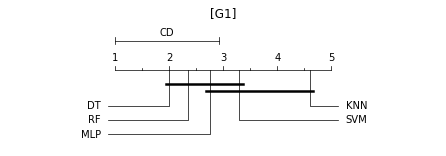

In [17]:
df_score_G1_class = friedman_nemenyi_tests_class(df_metrics_G1_class, "[G1]")

### Combinação [G2]

#### Busca dos melhores modelos

In [18]:
X = base_class.drop(columns = ['G1','G3']).to_numpy()
df_metrics_G2_class = search_class(X,y,n_splits,random_state,algorithms_class)

##### Performance dos modelos

In [19]:
df_metrics_G2_class

,MLP,SVM,KNN,DT,RF
0,0.876923,0.876923,0.846154,0.907692,0.953846
1,0.953846,0.953846,0.830769,0.938462,0.923077
2,0.892308,0.876923,0.861538,0.923077,0.938462
3,0.938462,0.923077,0.861538,0.938462,0.938462
4,0.876923,0.923077,0.815385,0.892308,0.892308
5,0.892308,0.876923,0.784615,0.830769,0.876923
6,0.876923,0.876923,0.846154,0.892308,0.923077
7,0.907692,0.892308,0.830769,0.923077,0.953846
8,0.923077,0.907692,0.815385,0.938462,0.953846
9,0.921875,0.921875,0.890625,0.921875,0.953125


In [20]:
df_metrics_G2_class.mean()

MLP    0.906034
SVM    0.902957
KNN    0.838293
DT     0.910649
RF     0.930697
dtype: float64

In [21]:
df_metrics_G2_class.std()

MLP    0.027489
SVM    0.027089
KNN    0.029790
DT     0.033028
RF     0.027310
dtype: float64

#### Teste de Friedman e Nemenyi (se necessário)

Statistics=25.947, p=3.24401e-05
Different distributions (reject H0)


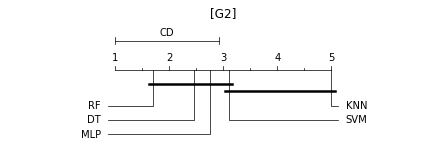

In [22]:
df_score_G2_class = friedman_nemenyi_tests_class(df_metrics_G2_class, "[G2]")

### Combinação [G1, G2]

#### Busca dos melhores modelos

In [23]:
X = base_class.drop(columns = ['G3']).to_numpy()
df_metrics_G1_G2_class = search_class(X,y,n_splits,random_state,algorithms_class)

##### Performance dos modelos

In [24]:
df_metrics_G1_G2_class

,MLP,SVM,KNN,DT,RF
0,0.923077,0.876923,0.861538,0.923077,0.923077
1,0.892308,0.938462,0.846154,0.938462,0.923077
2,0.892308,0.923077,0.861538,0.892308,0.923077
3,0.892308,0.923077,0.861538,0.923077,0.923077
4,0.892308,0.892308,0.815385,0.861538,0.938462
5,0.876923,0.846154,0.815385,0.876923,0.892308
6,0.923077,0.907692,0.846154,0.907692,0.969231
7,0.907692,0.923077,0.861538,0.938462,0.969231
8,0.953846,0.938462,0.830769,0.938462,0.953846
9,0.921875,0.890625,0.890625,0.921875,0.937500


In [25]:
df_metrics_G1_G2_class.mean()

MLP    0.907572
SVM    0.905986
KNN    0.849062
DT     0.912188
RF     0.935288
dtype: float64

In [26]:
df_metrics_G1_G2_class.std()

MLP    0.022847
SVM    0.029507
KNN    0.023499
DT     0.027134
RF     0.023822
dtype: float64

#### Teste de Friedman e Nemenyi (se necessário)

Statistics=27.099, p=1.89843e-05
Different distributions (reject H0)


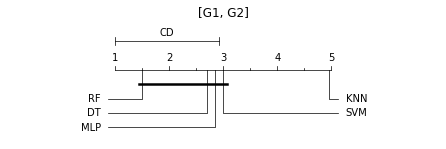

In [27]:
df_score_G1_G2_class = friedman_nemenyi_tests_class(df_metrics_G1_G2_class, "[G1, G2]")

---

## Tarefas de Regressão

### Função de pré-processamento

In [28]:
def preprocess_regr(base):

    base = base.drop(['school'], axis=1)
    base = base.replace(['LE3', 'GT3'], [0,1])
    items = ['sex', 'address','Pstatus','Mjob','Fjob','reason','guardian','schoolsup','famsup','paid','activities','nursery','higher',
             'internet','romantic']
    
    for item in items:
        base = pd.concat([base,pd.get_dummies(base[item], prefix=item)],axis=1)
        base = base.drop([item],axis=1)
        
    return base

### Função de treinamento e teste com base nos algoritmos escolhidos

In [29]:
def search_regr(X, y, n_splits, random_state, algorithms):
    kf = KFold(n_splits=10, shuffle=True, random_state=random_state)
    gskf = KFold(n_splits=3, shuffle=True, random_state=random_state)
    perf = mean_squared_error
    
    score = {}
    for algorithm in algorithms.keys():
        score[algorithm] = []
    
    for algorithm, (clf, parameters) in algorithms.items():
        for train, test in kf.split(X, y):
            prep = StandardScaler()
            
            prep.fit(X[train])
            
            best = GridSearchCV(clf, parameters, cv=gskf, scoring=make_scorer(perf))
            best.fit(prep.transform(X[train]), y[train])
            score[algorithm].append(perf(best.predict(prep.transform(X[test])), y[test]))
            
    df_metrics = pd.DataFrame.from_dict(score)
    return df_metrics

### Função que executa o teste de Friedman e Nemenyi (se necessário)

In [30]:
def friedman_nemenyi_tests_regr(df_metrics, title):   
    
    df_score = df_metrics.rank(axis=1, ascending=True)
    
    stat, p = friedmanchisquare(*[grp for idx, grp in df_score.iteritems()])
    
    print('Statistics=%.3f, p=%g' % (stat, p))
    
    alpha = 0.05
    if p > alpha:
        print('Same distributions (fail to reject H0)')
    else:
        print("Different distributions (reject H0)")
        names = list(df_score.columns)
        avranks = df_score.mean().values.tolist()
        cd = Orange.evaluation.compute_CD(avranks, n_splits)
        Orange.evaluation.graph_ranks(avranks, names, cd=cd, width=6, textspace=1.5)
        plt.title(title)
        plt.show()
    return df_score

### Algoritmos e hiperparâmetros testados

In [31]:
algorithms_regr = {
    "MLP": (MLPRegressor(), { "activation": ["identity", "tanh", "relu"], "solver": ["lbfgs", "adam"], "max_iter": [1500], "random_state": [1]}),
    "SVM": (SVR(), {"C": [1.0], "kernel": ("linear", "rbf", "poly", "sigmoid")}),
    "KNN": (KNeighborsRegressor(), { "n_neighbors": [1, 3, 5] }),
    "DT" : (DecisionTreeRegressor(), { "criterion": ("mse", "friedman_mse", "mae"), "max_depth": [5, 10, 20], "random_state": [3]}),
    "RF" : (RandomForestRegressor(), { "criterion": ("mse", "mae"), "max_depth": [5, 10, 20], "n_estimators": [30,50,100], "random_state": [4]})
}

### Leitura da base_regr, pré-processamento e definição do atributo-alvo

In [32]:
base_regr = preprocess_regr(base)

y = base_regr['G3'].to_numpy()

### Combinação [  ]

#### Busca dos melhores modelos

In [33]:
X = base_regr.drop(columns = ['G3', 'G1', 'G2']).to_numpy()
df_G3_regr = search_regr(X,y,n_splits,random_state,algorithms_regr)

##### Performance dos modelos

In [34]:
df_G3_regr

,MLP,SVM,KNN,DT,RF
0,8.957169,5.785633,13.123077,9.938462,5.077979
1,11.538370,6.292831,11.738462,8.015385,6.199209
2,16.097307,8.160290,12.215385,18.323077,8.923252
3,9.696998,5.773448,19.138462,15.184615,7.203675
4,13.456865,6.138146,12.569231,13.953846,6.535145
5,17.233510,16.053183,19.092308,16.861538,12.866480
6,14.039205,7.842609,17.153846,15.246154,5.278179
7,14.393651,12.526303,16.815385,21.588462,12.754197
8,9.988358,5.663563,8.923077,18.092308,6.362695
9,16.411241,7.982418,20.718750,14.412309,8.405768


In [35]:
df_G3_regr.mean()

MLP    13.181267
SVM     8.221842
KNN    15.148798
DT     15.161616
RF      7.960658
dtype: float64

In [36]:
df_G3_regr.std()

MLP    2.991014
SVM    3.441586
KNN    3.930556
DT     3.988256
RF     2.827182
dtype: float64

#### Teste de Friedman e Nemenyi (se necessário)

Statistics=31.120, p=2.8936e-06
Different distributions (reject H0)


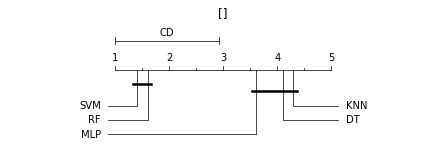

In [37]:
df_score_G3_regr = friedman_nemenyi_tests_regr(df_G3_regr, "[]")

### Combinação [G1]

#### Busca dos melhores modelos

In [38]:
X = base_regr.drop(columns = ['G3', 'G2']).to_numpy()
df_G3_from_G1_regr = search_regr(X,y,n_splits,random_state,algorithms_regr)

##### Performance dos modelos

In [39]:
df_G3_from_G1_regr

,MLP,SVM,KNN,DT,RF
0,3.715667,4.364121,10.692308,2.446154,1.911286
1,2.996901,4.458430,7.476923,3.292308,1.765890
2,4.951696,6.604778,12.153846,5.046154,2.855145
3,4.831358,4.001410,19.107692,4.461538,1.928355
4,4.292236,4.563790,10.061538,4.707692,2.833709
5,6.468854,13.241699,17.169231,12.169231,7.705094
6,5.101721,5.893028,12.923077,6.215385,2.825026
7,7.329069,10.403940,14.661538,13.646154,5.413111
8,4.114523,4.278252,7.492308,4.892308,2.422235
9,5.455326,6.531843,14.171875,6.582031,3.022731


In [40]:
df_G3_from_G1_regr.mean()

MLP     4.925735
SVM     6.434129
KNN    12.591034
DT      6.345895
RF      3.268258
dtype: float64

In [41]:
df_G3_from_G1_regr.std()

MLP    1.278988
SVM    3.067505
KNN    3.839398
DT     3.679477
RF     1.871177
dtype: float64

#### Teste de Friedman e Nemenyi (se necessário)

Statistics=34.000, p=7.45189e-07
Different distributions (reject H0)


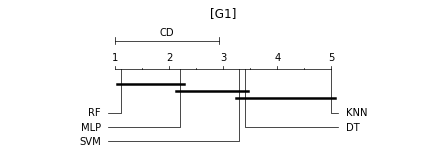

In [42]:
df_score_G3_from_G1_regr = friedman_nemenyi_tests_regr(df_G3_from_G1_regr, "[G1]")

### Combinação [G2]

#### Busca dos melhores modelos

In [43]:
X = base_regr.drop(columns = ['G3', 'G1']).to_numpy()
df_G3_from_G2_regr = search_regr(X,y,n_splits,random_state,algorithms_regr)

##### Performance dos modelos

In [44]:
df_G3_from_G2_regr

,MLP,SVM,KNN,DT,RF
0,2.346132,3.902207,10.676923,1.165193,0.956995
1,2.225586,3.767947,8.338462,1.015385,0.823286
2,3.874255,5.948658,11.353846,1.415385,1.228359
3,2.742985,3.803701,11.800000,1.646154,0.965723
4,2.080170,3.440498,9.630769,2.046154,0.735218
5,6.071004,11.284361,13.200000,5.707692,3.567915
6,2.472518,5.373102,10.907692,4.246154,1.773641
7,5.124111,9.330505,12.953846,5.276923,3.818191
8,2.788175,3.937623,7.646154,5.261538,1.513735
9,3.547446,5.775268,12.703125,2.203125,1.953598


In [45]:
df_G3_from_G2_regr.mean()

MLP     3.327238
SVM     5.656387
KNN    10.921082
DT      2.998370
RF      1.733666
dtype: float64

In [46]:
df_G3_from_G2_regr.std()

MLP    1.341583
SVM    2.651900
KNN    1.902654
DT     1.896704
RF     1.109656
dtype: float64

#### Teste de Friedman e Nemenyi (se necessário)

Statistics=37.040, p=1.76745e-07
Different distributions (reject H0)


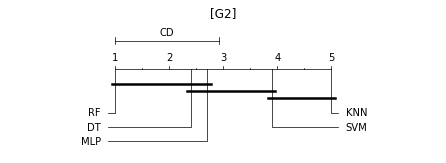

In [47]:
df_score_G3_from_G2_regr = friedman_nemenyi_tests_regr(df_G3_from_G2_regr, "[G2]")

### Combinação [G1, G2]

#### Busca dos melhores modelos

In [48]:
X = base_regr.drop(columns = ['G3']).to_numpy()
df_G3_from_G1_G2_regr = search_regr(X,y,n_splits,random_state,algorithms_regr)

##### Performance dos modelos

In [49]:
df_G3_from_G1_G2_regr

,MLP,SVM,KNN,DT,RF
0,2.337539,2.858850,8.553846,5.676923,0.872974
1,1.863278,2.639468,7.092308,1.292308,0.901299
2,3.167137,4.872657,9.969231,3.415385,1.050137
3,2.258027,2.723089,10.492308,1.876923,0.904372
4,1.729284,2.507124,8.846154,1.454102,0.843355
5,4.580210,9.462763,11.969231,5.815385,3.469983
6,2.801276,4.126367,10.107692,3.846154,1.598603
7,5.333137,8.026512,11.938462,4.692308,3.481333
8,1.755958,3.018870,6.800000,3.080769,1.345868
9,3.131848,4.784033,8.781250,2.015625,1.888123


In [50]:
df_G3_from_G1_G2_regr.mean()

MLP    2.895769
SVM    4.501973
KNN    9.455048
DT     3.316588
RF     1.635605
dtype: float64

In [51]:
df_G3_from_G1_G2_regr.std()

MLP    1.218407
SVM    2.424461
KNN    1.780245
DT     1.679460
RF     1.029924
dtype: float64

#### Teste de Friedman e Nemenyi (se necessário)

Statistics=35.920, p=3.00545e-07
Different distributions (reject H0)


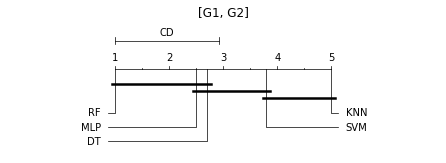

In [52]:
df_score_G3_from_G1_G2_regr = friedman_nemenyi_tests_regr(df_G3_from_G1_G2_regr, "[G1, G2]")